In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam, Adagrad, Adadelta, Ftrl
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [71]:
data = pd.read_csv('AUBANK_minute.csv')

In [72]:
data.dtypes

date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701932 entries, 0 to 701931
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    701932 non-null  object 
 1   open    701932 non-null  float64
 2   high    701932 non-null  float64
 3   low     701932 non-null  float64
 4   close   701932 non-null  float64
 5   volume  701932 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 32.1+ MB


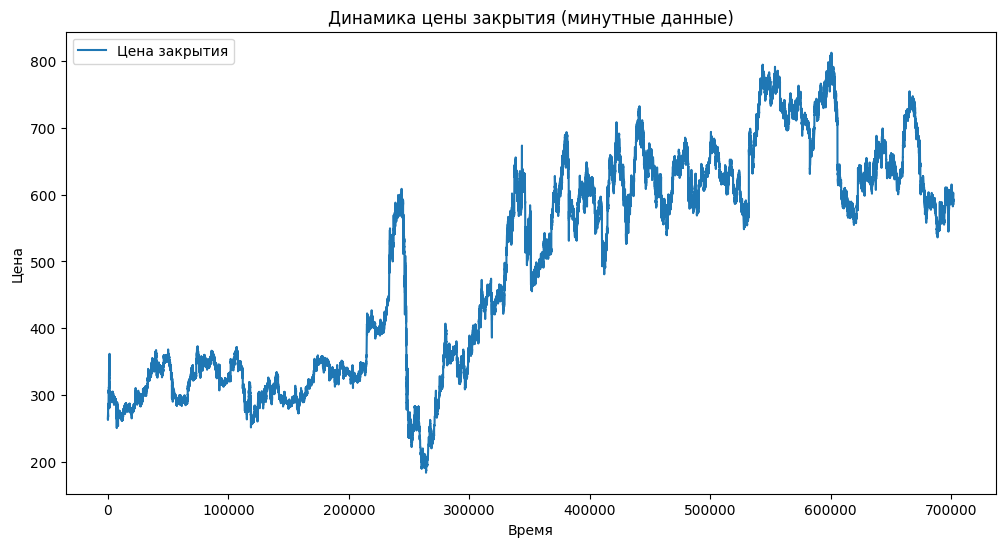

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["close"], label="Цена закрытия")
plt.title("Динамика цены закрытия (минутные данные)")
plt.xlabel("Время")
plt.ylabel("Цена")
plt.legend()
plt.show()

In [75]:
def data_load(file_path, test_size):
    data = pd.read_csv(file_path)
    
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    data = data.sort_index()

    for i in range(1, 6):
        data[f'lag_{i}_close'] = data['close'].shift(i)
    
    data = data.dropna()
    
    features = ['open', 'high', 'low', 'volume'] + [f'lag_{i}_close' for i in range(1, 6)]
    target = 'close'
    
    X = data[features].values.astype('float32')
    y = data[target].values.astype('float32').reshape(-1, 1)
    
    X_train_raw, X_test_raw = X[:-test_size], X[-test_size:]
    y_train_raw, y_test_raw = y[:-test_size], y[-test_size:]
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train = scaler_X.fit_transform(X_train_raw)
    X_test = scaler_X.transform(X_test_raw)
    
    y_train = scaler_y.fit_transform(y_train_raw)
    y_test = scaler_y.transform(y_test_raw)
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

In [85]:
def create_model(optimizer="adam", learning_rate=0.001, momentum=0.9, dropout_rate=0.0, beta_1=0.9, beta_2=0.999, l1=0.0, l2=0.0):
    model = Sequential()
    
    model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(64, activation='relu'))
    if dropout_rate > 0.0:
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1))
    
    if optimizer == 'sgd':  
        opt = SGD(learning_rate=learning_rate, momentum=0.0)
    elif optimizer == 'momentum':
        opt = SGD(learning_rate=learning_rate, momentum=momentum)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
    elif optimizer == "nadam":
        opt = Nadam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
    elif optimizer == "amsgrad":  
        opt = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, amsgrad=True)
    elif optimizer == "adadelta":
        opt = Adadelta(learning_rate=1.0)
    elif optimizer == "ftrl":
        opt = Ftrl(learning_rate=learning_rate, l1_regularization_strength=l1, l2_regularization_strength=l2)
    
    model.compile(optimizer=opt, loss='mse')
    return model

In [77]:
def plot_results(train_data, test_data, history):
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('График потерь(MSE)')
    plt.xlabel('Эпоха')
    plt.ylabel('MSE')
    plt.legend()
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_data['true'], label='True')
    plt.plot(train_data['pred'], label='Predicted')
    plt.title(f'MSE: {train_data["mse"]:.2f}, MAE: {train_data["mae"]:.2f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(test_data['true'], label='True')
    plt.plot(test_data['pred'], label='Predicted')
    plt.title(f'MSE: {test_data["mse"]:.2f}, MAE: {test_data["mae"]:.2f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [78]:
def evaluate_model(model, X, y, scaler_y):
    y_pred = model.predict(X)
    return {
        'true': scaler_y.inverse_transform(y),
        'pred': scaler_y.inverse_transform(y_pred)}

def calculate_metrics(true, pred):
    return {
        'mse': mean_squared_error(true, pred),
        'mae': mean_absolute_error(true, pred)}


In [79]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = data_load('AUBANK_minute.csv', test_size=50)

model = create_model(
    optimizer='sgd',
    learning_rate=0.1
)

start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=len(X_train),
    validation_split=0.2,
    verbose=0
)
training_time = time.time() - start_time

train_results = evaluate_model(model, X_train, y_train, scaler_y)
test_results = evaluate_model(model, X_test, y_test, scaler_y)

train_metrics = calculate_metrics(train_results['true'], train_results['pred'])
test_metrics = calculate_metrics(test_results['true'], test_results['pred'])

print(f"\nВремя обучения: {training_time:.1f} сек")
print("\nМетрики модели:")
print(f"Тренировочные данные - MSE: {train_metrics['mse']:.2f}, MAE: {train_metrics['mae']:.2f}")
print(f"Тестовые данные - MSE: {test_metrics['mse']:.2f}, MAE: {test_metrics['mae']:.2f}")

2/2 [==============================] - 0s 0s/step

Время обучения: 207.0 сек

Метрики модели:
Тренировочные данные - MSE: 1.00, MAE: 0.55
Тестовые данные - MSE: 0.82, MAE: 0.65


Графики для gd


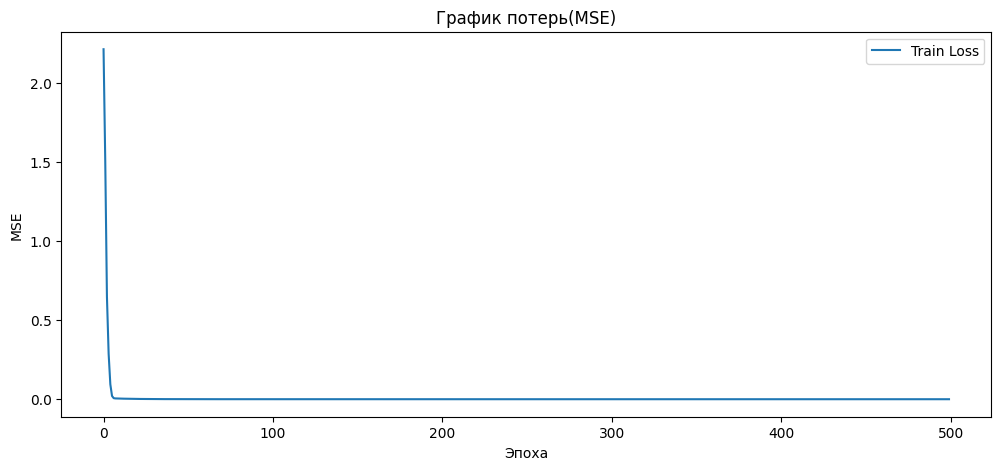

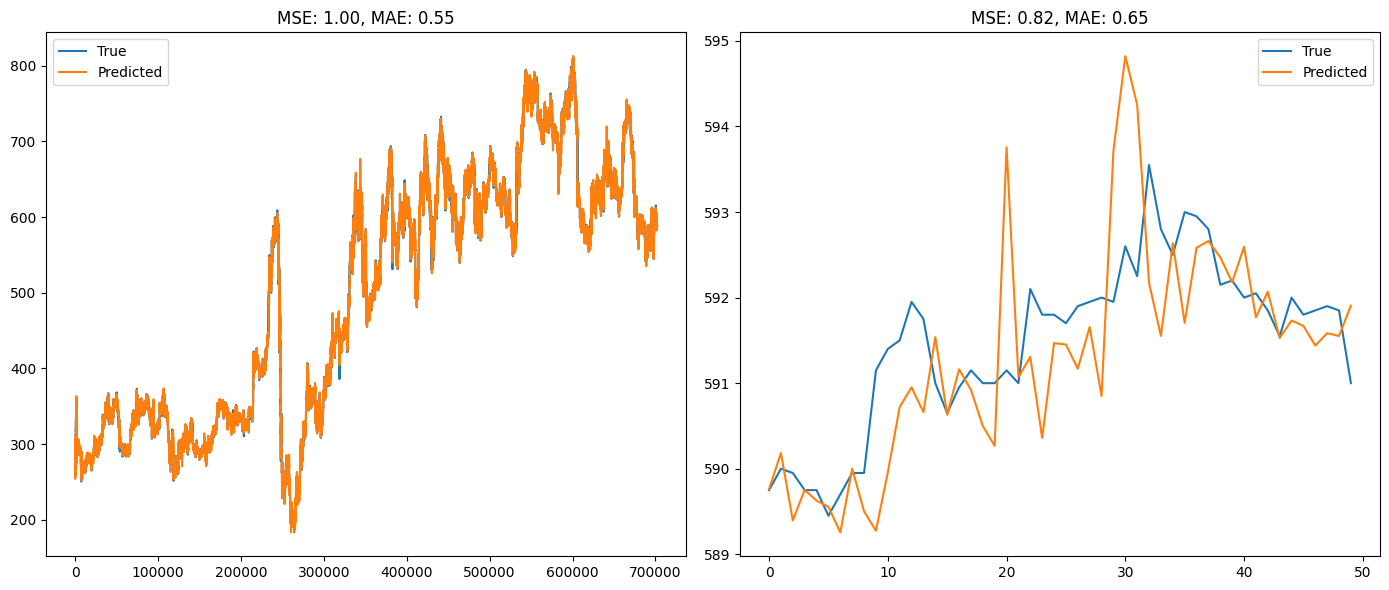

In [80]:
print('Графики для gd')
plot_results(train_data={**train_results, **train_metrics}, test_data={**test_results, **test_metrics}, history=history)

In [81]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = data_load('AUBANK_minute.csv', test_size=50)

model = create_model(
    optimizer='adam',
    learning_rate=0.01
)

start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.2,
    verbose=0
)
training_time = time.time() - start_time

train_results = evaluate_model(model, X_train, y_train, scaler_y)
test_results = evaluate_model(model, X_test, y_test, scaler_y)

train_metrics = calculate_metrics(train_results['true'], train_results['pred'])
test_metrics = calculate_metrics(test_results['true'], test_results['pred'])

print(f"\nВремя обучения: {training_time:.1f} сек")
print("\nМетрики модели:")
print(f"Тренировочные данные - MSE: {train_metrics['mse']:.2f}, MAE: {train_metrics['mae']:.2f}")
print(f"Тестовые данные - MSE: {test_metrics['mse']:.2f}, MAE: {test_metrics['mae']:.2f}")

2/2 [==============================] - 0s 508us/step

Время обучения: 105.5 сек

Метрики модели:
Тренировочные данные - MSE: 0.55, MAE: 0.51
Тестовые данные - MSE: 0.22, MAE: 0.40


Графики для adam


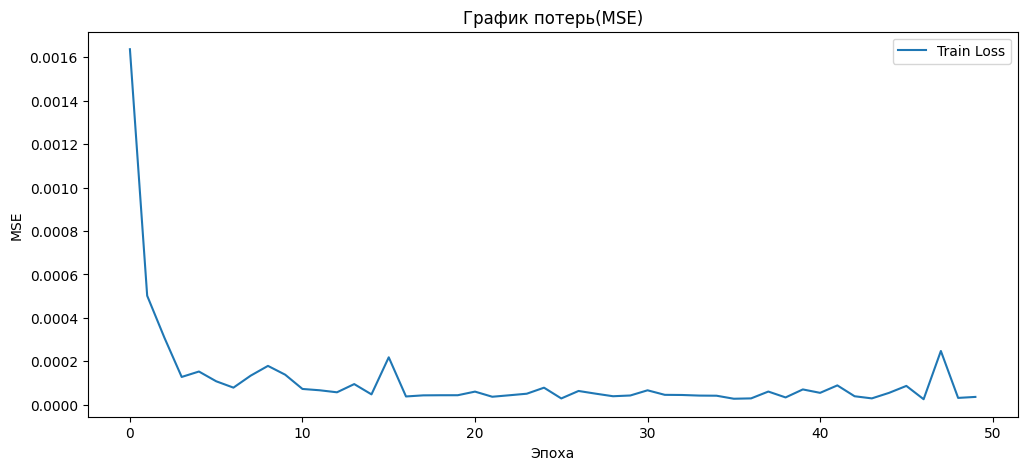

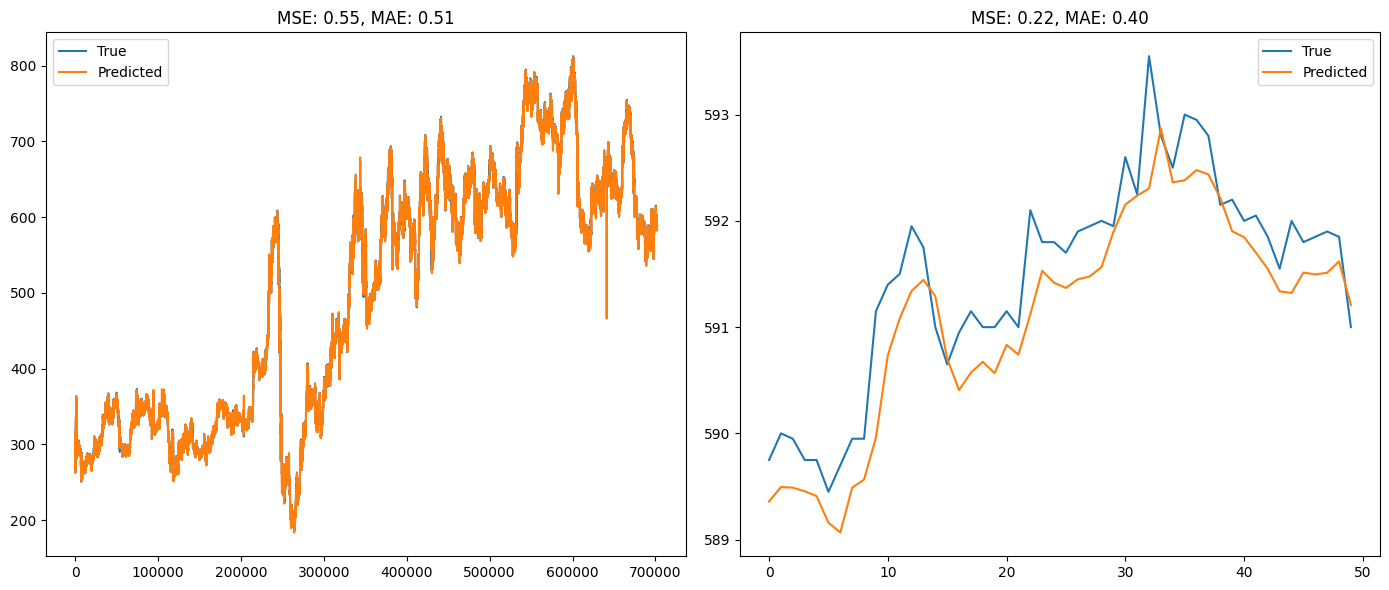

In [82]:
print('Графики для adam')
plot_results(train_data={**train_results, **train_metrics}, test_data={**test_results, **test_metrics}, history=history)

In [86]:
import optuna

def objective(trial):
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop', 'nadam', 'amsgrad', 'adadelta', 'ftrl'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    momentum = trial.suggest_float('momentum', 0.0, 0.9) if optimizer in ['momentum', 'sgd'] else 0.0

    beta_1 = trial.suggest_float('beta_1', 0.8, 0.999) if optimizer in ['adam', 'nadam', 'amsgrad'] else 0.9
    beta_2 = trial.suggest_float('beta_2', 0.9, 0.9999) if optimizer in ['adam', 'nadam', 'amsgrad'] else 0.999
    l1 = trial.suggest_float('l1', 1e-5, 1e-1, log=True) if optimizer == 'ftrl' else 0.0
    l2 = trial.suggest_float('l2', 1e-5, 1e-1, log=True) if optimizer == 'ftrl' else 0.0

    model = create_model(
        optimizer=optimizer,
        learning_rate=learning_rate,
        momentum=momentum,
        dropout_rate=dropout_rate,
        beta_1=beta_1,
        beta_2=beta_2,
        l1=l1,
        l2=l2
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=50, 
        batch_size=batch_size,
        validation_split=0.2,
        verbose=0
    )
    
    
    return min(history.history['val_loss'])


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)


print("Лучшие параметры:")
best_params = study.best_params
print(best_params)

[I 2025-05-01 18:01:48,297] A new study created in memory with name: no-name-fb0668cb-a0a2-4bc5-b6de-627da8a90116
[I 2025-05-01 18:04:21,218] Trial 0 finished with value: 0.00024459848646074533 and parameters: {'optimizer': 'ftrl', 'learning_rate': 0.0004623533452008151, 'dropout_rate': 0.0660961622656357, 'batch_size': 256, 'l1': 0.0022204636129123066, 'l2': 0.0007091778548644772}. Best is trial 0 with value: 0.00024459848646074533.
[I 2025-05-01 18:06:49,695] Trial 1 finished with value: 0.00012106927169952542 and parameters: {'optimizer': 'adadelta', 'learning_rate': 0.00038071237549152905, 'dropout_rate': 0.428440524683197, 'batch_size': 256}. Best is trial 1 with value: 0.00012106927169952542.
[I 2025-05-01 18:09:18,087] Trial 2 finished with value: 0.00022455699217971414 and parameters: {'optimizer': 'amsgrad', 'learning_rate': 0.00017721757750113884, 'dropout_rate': 0.06234361685233469, 'batch_size': 256, 'beta_1': 0.995587935401014, 'beta_2': 0.929305350159533}. Best is trial 1

Лучшие параметры:
{'optimizer': 'nadam', 'learning_rate': 7.089915400133476e-05, 'dropout_rate': 0.0015577920775282361, 'batch_size': 64, 'beta_1': 0.8789673549000729, 'beta_2': 0.950331299199137}


In [89]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = data_load('AUBANK_minute.csv', test_size=50)

model = create_model(
    optimizer='nadam',
    learning_rate=7.089915400133476e-05,
    dropout_rate=0.0015577920775282361,
    beta_1=0.8789673549000729,
    beta_2=0.950331299199137
)

start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=0
)
training_time = time.time() - start_time

train_results = evaluate_model(model, X_train, y_train, scaler_y)
test_results = evaluate_model(model, X_test, y_test, scaler_y)

train_metrics = calculate_metrics(train_results['true'], train_results['pred'])
test_metrics = calculate_metrics(test_results['true'], test_results['pred'])

print(f"\nВремя обучения: {training_time:.1f} сек")
print("\nМетрики модели:")
print(f"Тренировочные данные - MSE: {train_metrics['mse']:.2f}, MAE: {train_metrics['mae']:.2f}")
print(f"Тестовые данные - MSE: {test_metrics['mse']:.2f}, MAE: {test_metrics['mae']:.2f}")

2/2 [==============================] - 0s 0s/step

Время обучения: 513.6 сек

Метрики модели:
Тренировочные данные - MSE: 0.32, MAE: 0.43
Тестовые данные - MSE: 0.08, MAE: 0.23


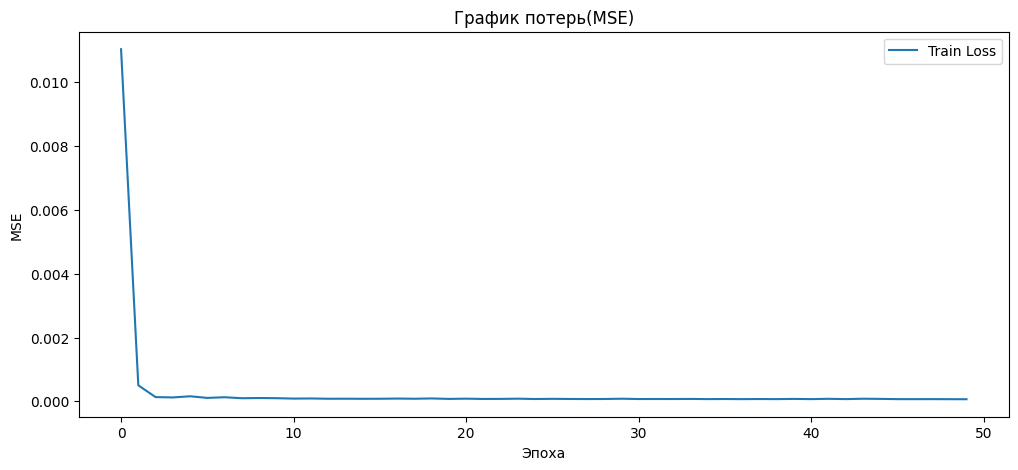

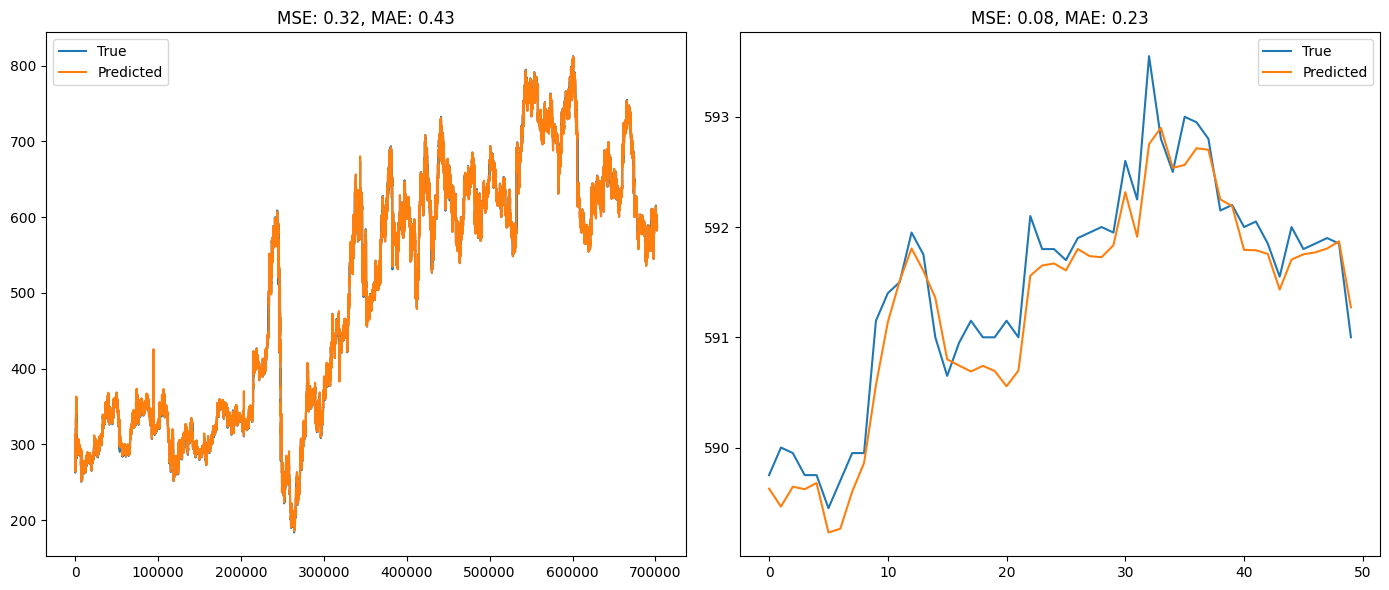

In [90]:
plot_results(train_data={**train_results, **train_metrics}, test_data={**test_results, **test_metrics}, history=history)